In [1]:
#| default_exp data_man
%reload_ext autoreload
%autoreload 2
from nbdev.showdoc import *
from utilities.ipynb_docgen import *

## Overview

Fermi-LAT weekly data files are extracted from the [GSFC FTP server ](https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly), 
with subfolders for the photon data, `photon` and spacecraft data, `spacecraft`. It is [described here](http://fermi.gsfc.nasa.gov/ssc/data/access/http://fermi.gsfc.nasa.gov/ssc/data/access/)

The class `FermiData` downloads these to temporary files and constructs a dict for each week with
contents

* photons: a table, one entry per selected photon with columns, converted with `get_ft1_data`
  * `run_ref` (uint8), index into the `runs` list
  * time since the run start, in 2 $\mu$s intervals  (uint32)
  * energy and event type (uint8)
  * position as HEALPix index with nside, nest from Config, currently 1024, True (uint32) 
  
* sc_data: a table, one entry per 30-s interval, with columns, all float32, converted with `get_ft2_info`
  * start/stop time 
  * S/C direction 
  * zenith direction
* runs list of run numbers
* gti_times: an array of interleaved start/stop intervals
* file_date: modification date for the FT1 file at GSFC.

These dict objects are saved in a folder specfied by `Config().datapath`. Its contents can be 
checked with `check_data`, and updated using `update_data`.  The contents of a week can be visually 
inspected with `plot_week`.

### Run numbers and timing

The run number is an integer correspnding to the MET at the start of the run. For a week, with 15 orbits/day, we 
expect ~105 runs. We save a table of the run numbers per week, and use a uint8 index in the photon table.

A run is typically an orbit or less, at most 6 ks. Integerizing the offset from the run start, or the run number, using 32 bits, one has 5e5 intervals/s, so we choose 2$\mu$s. Thus we generate the time for each event from three sources: the 2$\mu$s time offset for the run, the index of the run number into the  runs table, and the runs table itself.


In [2]:
#| export
import os, sys, pickle
import dateutil, datetime
from astropy.io import fits
from ftplib import FTP_TLS as FTP

import healpy
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wtlike.config import Config, Timer, UTC, MJD, mjd_range, mission_week

## GTI
GTI, for Good Time Interval, is a mechanism to select event times, and corresponding spacecraft 
information if exposure is needed.
There is a section for this information in the FT1 photon data files, but, for the GSFC-generated
weekly files we use here, we do not use it, since the 
photon data itself respects it, as do the space craft information in the FT2 files. This code is intended to support external use.

In [3]:
#| export

class GTI(object):
    """ Define a functor that returns acceptability of times
    Note, internally use MJD time scale

    """    
    def __init__(self, times:[], 
                 name:str='', 
                 **kwargs):
        """ times: interleaved (start,stop) times in MJD
            namme to associte?"""
        self.times = times
        self.name = name
        if np.any(np.diff(self.times)<0):
            raise ValueError( f'Bad input data from expect ascending time values.')
        
    def plot(self, ax=None, **kwargs):
        """ plot exclusion time and duration
        """        
        fstart = self.times[0::2]
        delta = np.diff(self.times)[::2]
        fig, ax = plt.subplots(figsize=(8,2)) if ax is None else (ax.figure, ax)
        ax.semilogy(fstart, delta, '+');
        ax.grid(alpha=0.5)
        kw= dict(xlabel='MJD', xlim=(54500, 60000),ylabel='Duration (d)', 
                 title=f'{self.name}: {len(fstart)} exclusions')
        kw.update(kwargs)
        ax.set(**kw)
        
    def add(self, other):
        """Combine with another GTI.
        Require that there is no overlap of the excluded regions.
        """
        assert np.all(self(other.times)), 'Can only combine if no overlaps of excluded regions'
        self.times = np.sort(np.hstack([self.times, other.times]))
        self.name += ('+ '+other.name)
        
    def __repr__(self):
        return f'GTI {self.name} has {len(self.times)//2}'\
                f' excluded intervals, total {np.sum(np.diff(self.times)[0::2]):.3f} d.'
    
    def __str__(self): return self.__repr__()

    def __call__(self, times):
        """
        return array of bool for accepability of times 
        """
        # searchsorted index must be even
        return np.searchsorted(self.times, times) & 1 ==0
    
    @classmethod
    def from_FITS(cls, gti_file:'File name, either absolute or in datapath', 
                        config:'Config | None'=None):
        """    
        - gti_file: a FITS file name with columns START,STOP, MET times in HDU[1]
        
        Interleave, convert to MJD for GTI setup.
        
        """
        
        from astropy.io import fits
                
        config = config or Config()
        filepath = gti_file if Path(gti_file).is_file() else Path(config.datapath)/gti_file
        if not filepath.is_file():
            raise ValueError(f'Input filename "{gti_file}" is not a file.')
        with  fits.open(filepath.absolute()) as hdus:
            hdu = hdus['GTI']
            header, data = hdu.header, hdu.data
        # create interlavet  (start, stpo) pairs
        a,b = sorted(data.START), sorted(data.STOP)
        times = MJD(np.ravel(np.column_stack((a,b))))[1:-1] #remove first, last
        return cls(times, name=gti_file)
    
    def to_HDU(self):
        """Return a FITS HDU
        """
        def MET(mjd):
            """Convert MJD to MET
            """
            from wtlike.config import mission_start,day
            return (mjd-mission_start) * day 
        raise NotImplementedError('todo')

In [4]:
show_doc(GTI,title_level=3)
show_doc(GTI.__call__)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/data_man.py#L63){target="_blank" style="float:right; font-size:smaller"}

### GTI.__call__

>      GTI.__call__ (times)

return array of bool for accepability of times

In [5]:
#| include: false
week = '726'
display_markdown(f""" ### Check GTI for week {week}
__FT1__<br>
This file defines a GTI that should be applied to the data, and corresponding spacecraft (FT2) info.

For GSFC weekly files it is redundant since it has already been applied. I check that here.

""")
ft1_file = Path(f'/tmp/from_gsfc/week{week}_ft1.fits').absolute()
if not ft1_file.exists():
    print(f'File {ft1_file} not present.')
else:
    with fits.open(ft1_file) as ft1:
        print(ft1.info())
        gti = GTI.from_FITS(ft1_file)
        print(gti)
        t1 = MJD(ft1['EVENTS'].data.TIME) 
    gti.plot(xlim=None)
    print(f'Event times: {len(t1):9,} events from {t1.min():.2f} to {t1.max():.2f}')
    print(f'GTI fails:   {sum(~gti(t1)):9} events')
    
    display_markdown('__FT2__')
    ft2_file = Path(f'/tmp/from_gsfc/week{week}_ft2.fits')
    with fits.open(ft2_file.absolute()) as ft2:
        print(ft2.info())
        ft2_data = ft2['SC_DATA'].data
        t2 = MJD((ft2_data.START+ft2_data.STOP)/2)
    print(f'FT2 times: {len(t2):6,} intervals from {t2.min():.2f} to {t2.max():.2f}')
    print(f'GTI fails: {sum(~gti(t2)):6d}')

Obsolete: use "show"


### Check GTI for week 726
__FT1__<br>
This file defines a GTI that should be applied to the data, and corresponding spacecraft (FT2) info.

For GSFC weekly files it is redundant since it has already been applied. I check that here.

File /tmp/from_gsfc/week726_ft1.fits not present.


### Apply an external GTI

Copied the files nogrb.gti and nosolorflares.gti from /nfs/farm/g/glast/g/catalog/P8_P305 to config.datapath

Obsolete: use "show"


#### Test GTI with gti files

GTI nogrb.gti has 36 excluded intervals, total 0.472 d.
GTI nosolarflares.gti has 28 excluded intervals, total 6.750 d.
GTI nogrb.gti+ nosolarflares.gti has 64 excluded intervals, total 7.222 d.


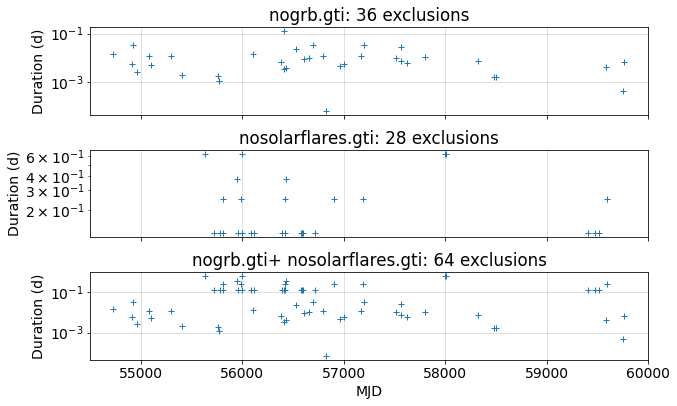

In [6]:
#| include: false 
def GTI_test():
    import matplotlib.pyplot as plt
    display_markdown('#### Test GTI with gti files')
    fig, (ax1,ax2, ax3) = plt.subplots(nrows=3, figsize=(10,6), sharex=True)
    plt.subplots_adjust(hspace=0.4)

    a = GTI.from_FITS('nogrb.gti'); print(a)
    a.plot(ax=ax1,xlabel='')
    b = GTI.from_FITS('nosolarflares.gti'); print(b)
    b.plot(ax=ax2, xlabel='')
    a.add(b); print(a)
    a.plot(ax=ax3)
GTI_test()

In [7]:
display_markdown("""\
## FT1 and FT2 -- data access

Fermi data is distributed in two FITS file formats:
- FT1: photon data
- FT2: spacecraft history
""")

Obsolete: use "show"


## FT1 and FT2 -- data access

Fermi data is distributed in two FITS file formats:
- FT1: photon data
- FT2: spacecraft history

In [8]:
#| export
def get_ft1_data( config, ft1_file):

    """
    Read in a photon data (FT1) file, bin in energy and position to convert to a compact table

    - `ft1_file` -- A weekly file from GSFC

    Depends on config items
    - `theta_cut, z_cut` -- selection criteria
    - `ebins, etypes` -- define band index
    - `nside, nest` -- define HEALPix binning

    Returns a dict with keys

    - `tstart`, the start MET time from the FT1 header

    - `photons`: a dict with keys and entries for each selected photon
       - `band` (uint8):    energy band index*2 + 0,1 for Front/Back
       - `nest_index`  if nest else `ring_index` (uint32): HEALPIx index for the nside
       - `run_ref` (uint8) reference to the run number, in the array `runs`
       - `trun` (unit32): time since the run id in 2 $\\mu s$ units

    - `gti_times` -- GTI times as an interleaved start, stop array.
    - `runs` -- a list of the run numbers, each a MET time. Expect ~109 per week

    For the selected events above 100 MeV, this represents 10 bytes per photon, vs. 27 in the FT1 data
    """

    delta_t = config.offset_size
    ebins =   config.energy_edges
    etypes=   config.etypes
    nside =   config.nside
    nest  =   config.nest
    z_cut =   config.z_max
    theta_cut = np.degrees(np.arccos(config.cos_theta_max))
    verbose = config.verbose

    with  fits.open(ft1_file) as ft1:
        tstart = ft1[1].header['TSTART']

        ## GTI - setup raveled array function to make cut
        gti_data= ft1['GTI'].data
        # extract arrays for values of interest
        data =ft1['EVENTS'].data

    a,b = sorted(gti_data.START), sorted(gti_data.STOP)

    gti_times = np.ravel(np.column_stack((a,b)))
    if np.any(np.diff(gti_times)<0):
        raise ValueError(f'Non-monatonic GTI found in file {ft1_file}')


    # apply  selections

    sel =  ((data['ENERGY'] > ebins[0]) &
            (data['ZENITH_ANGLE'] < z_cut) &
            (data['THETA'] < theta_cut))

    dsel = data[sel]

    # get the columns for output
    glon, glat, energy, et, z, theta, time, ec =\
         [dsel[x] for x in 'L B ENERGY EVENT_TYPE ZENITH_ANGLE THETA TIME EVENT_CLASS'.split()]

    # generate event_type masks
    et_mask={}
    for ie in etypes:
        et_mask[ie]= et[:,-1-ie]


    if verbose>2:
        total = sum(b)-sum(a)
        fraction = total/(b[-1]-a[0])

        print(  f'FT1: {ft1_file.name}, GTI range {a[0]:.1f}-{b[-1]:.1f}:  {len(data):,} photons'\
                f'\n\tSelection E > {ebins[0]:.0f} MeV. theta<{theta_cut:.1f} and z<{z_cut} remove:'\
                f' {100.- 100*len(dsel)/float(len(data)):.2f}%'
             )

    # pixelate direction
    hpindex = healpy.ang2pix(nside, glon, glat, nest=nest, lonlat=True).astype(np.uint32)
    hpname = 'nest_index' if nest else 'ring_index'

    # digitize energy and create band index incluing (front/back)
    band_index = (2*(np.digitize(energy, ebins, )-1) + et_mask[1]).astype(np.uint8)

    #
    run_id = dsel['RUN_ID'].astype(np.uint32)

    # save this for for run reference
    runlist = np.unique(run_id)

    # a dict with all photon info, which requires runlist
    runs = np.unique(run_id)
    photons = {'band' : band_index,
              hpname : hpindex,
              'run_ref': np.searchsorted(runs, run_id).astype(np.uint8),
              'trun'  : ((time-run_id)/delta_t).astype(np.uint32),
             }

    if verbose>1:
        print(f'FT1 data from file {ft1_file.name}: tstart={tstart:.0f} (UTC {UTC(MJD(tstart))[:-6]})'
              f' selected {len(dsel):,}/{len(data):,} photons, in {len(runlist)} runs.')

    return  dict(tstart=tstart, 
                 photons=photons,
                 gti_times=gti_times,
                 runlist=runlist)

In [9]:
show_doc(get_ft1_data, title_level=3)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/data_man.py#L105){target="_blank" style="float:right; font-size:smaller"}

### get_ft1_data

>      get_ft1_data (config, ft1_file)

Read in a photon data (FT1) file, bin in energy and position to convert to a compact table

- `ft1_file` -- A weekly file from GSFC

Depends on config items
- `theta_cut, z_cut` -- selection criteria
- `ebins, etypes` -- define band index
- `nside, nest` -- define HEALPix binning

Returns a dict with keys

- `tstart`, the start MET time from the FT1 header

- `photons`: a dict with keys and entries for each selected photon
   - `band` (uint8):    energy band index*2 + 0,1 for Front/Back
   - `nest_index`  if nest else `ring_index` (uint32): HEALPIx index for the nside
   - `run_ref` (uint8) reference to the run number, in the array `runs`
   - `trun` (unit32): time since the run id in 2 $\mu s$ units

- `gti_times` -- GTI times as an interleaved start, stop array.
- `runs` -- a list of the run numbers, each a MET time. Expect ~109 per week

For the selected events above 100 MeV, this represents 10 bytes per photon, vs. 27 in the FT1 data

In [10]:
#| include: false
# def photon_week(config, week_dict):
#     """
#     Return a dict with photon info for the week, with a 'time' field, in MJD reconstructed from
#     the run_ref and trun fields. The latter removed.

#     - week_dict -- standard photon info for the week
#     - config -- used for config.offset_size

#     """
#     delta_t = config.offset_size
#     phd = week_dict['photons'].copy()
#     rl = week_dict['runlist']
#     phd['time'] = MJD(phd['trun']* delta_t + rl[phd['run_ref']]) #- week_dict['tstart']
#     phd.pop('run_ref')
#     phd.pop('trun')
#     return phd

In [11]:
#| export
def get_ft2_info(config, filename,
                 gti = lambda x: np.ones_like(x).astype(bool)):
    """Process a FT2 file, with S/C history data, and return a summary dict

    Parameters:

    * config -- verbose, cos_theta_max, z_max
    * filename -- spacecraft (FT2) file
    * gti -- GTI object that checkes for allowed intervals, in MJD units

    Returns: A dict with fields consistent with GTI if specified

    * start, stop -- interval in MJD units
    * livetime -- sec
    * ra_scz, dec_scz --spaceraft direction
    * ra_zenith, dec_zenith -- local zenith
    """
    # combine the files into a dict  with following fields besides START and STOP (lower case for column)
    fields    = ['LIVETIME','RA_SCZ','DEC_SCZ', 'RA_ZENITH','DEC_ZENITH']
    with fits.open(filename) as hdu:
        scdata = hdu['SC_DATA'].data
        tstart, tstop = [float(hdu[0].header[field]) for field in  ('TSTART','TSTOP') ]

    if config.verbose>1:
        print(f'FT2: {filename.name}, MET range {tstart:.1f}-{tstop:.1f},', end='')# {"not" if gti is None else ""} applying GTI')

    # get times to check against MJD limits and GTI
    start, stop = [MJD(np.array(scdata.START, float)),
                   MJD(np.array(scdata.STOP, float))]

    # apply GTI to bin center (avoid edge effects?)
    in_gti = np.array(gti(0.5*(start+stop)))
    if config.verbose>1:
        s = sum(in_gti)
        print(f' {len(start)} entries, {s} ({100*s/len(start):.1f}%) in GTI')

    t = [('start', start[in_gti]), ('stop',stop[in_gti])]+\
        [(field.lower(), np.array(scdata[field][in_gti],np.float32)) for field in fields ]

    sc_data = dict(t)
    return sc_data

In [12]:
show_doc(get_ft2_info, title_level=3)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/data_man.py#L215){target="_blank" style="float:right; font-size:smaller"}

### get_ft2_info

>      get_ft2_info (config, filename, gti=<function <lambda>>)

Process a FT2 file, with S/C history data, and return a summary dict

Parameters:

* config -- verbose, cos_theta_max, z_max
* filename -- spacecraft (FT2) file
* gti -- GTI object that checkes for allowed intervals, in MJD units

Returns: A dict with fields consistent with GTI if specified

* start, stop -- interval in MJD units
* livetime -- sec
* ra_scz, dec_scz --spaceraft direction
* ra_zenith, dec_zenith -- local zenith

## FermiData
With superclass GSFCweekly, organize the weekly FT1 and FT2 files from GSFC into local weekly summary files

In [13]:
#| exporti
def filepaths(week):
    """Returns: A tuple with two elements for the week number, each with two triplets with:
        ftp folder, ftp filename, local simple filename
    """
    urls = []
    for ftype, alias in  [('spacecraft','ft2'), ('photon','ft1')]:
         urls.append((
             f'{ftype}',
             f'lat_{ftype}_weekly_w{week:03d}_p{"305" if ftype=="photon" else "310" }_v001.fits',
             f'week{week:03d}_{alias}.fits',
            ))
    return urls

In [14]:
#| exporti
class GSFCweekly(dict):

    ftp_site = 'heasarc.gsfc.nasa.gov'
    ftp_path = 'fermi/data/lat/weekly'
    local_path  = '/tmp/from_gsfc'

    def __init__(self, config=None):
        """ Obtain lists of the weekly FT1 and FT2 files at GSFC, Set up as a dict, with
        keys= week numbers, values=mofification date strings
        """
        self.config = config or Config()
        # self.wtlike_data_file_path = Path(self.config.datapath/'data_files')
        # assert self.wtlike_data_file_path.is_dir(), 'Data path invalid'
        # os.makedirs(self.local_path, exist_ok=True)
        try:
            with FTP(self.ftp_site) as ftp:
                ftp.login()
                ftp.prot_p()
                ftp.cwd(self.ftp_path+'/photon') # or spacecraft
                # aet modification time and type for all files in folder

                parse_week = lambda fn:  int(fn.split('_')[3][1:])
                flist = ftp.mlsd(facts=['modify', 'type'])
                self.fileinfo = sorted([(parse_week(name), fact['modify']) for name,fact in flist
                                 if fact['type']=='file' and name.startswith('lat') ])
        except Exception as msg:
            print(f'FTP login to or download from {self.ftp_site} failed:\n\t--> {msg}',file=sys.stderr)
            self.valid=False
            return
        self.update(self.fileinfo)
        self.valid=True

    def download(self, week):
        """ Download the given week's files to the local folder

        week -- the mission week number, starting at 9. If negative, get recent one

        return the ft1, ft2 local filenames
        """

        if week<0:
            week = list(self.keys())[week]
        assert week in self, f'week {week} not found at FTP site'
        files = []
        with FTP(self.ftp_site) as ftp:
            ftp.login()
            ftp.prot_p()
            for ftp_folder, ftp_filename, local_filename in filepaths(week):
                ftp.cwd('/'+self.ftp_path+'/'+ftp_folder)
                if self.config.verbose>0:
                    print(f'GSFCweekly: {ftp_folder}/{ftp_filename} --> {local_filename}', flush=True)
                with open(f'{self.local_path}/{local_filename}', 'wb') as  localfile:
                    ftp.retrbinary('RETR ' + ftp_filename, localfile.write)
                files.append(local_filename)
        return files

    def week_number(self, met):
        return (met-233711940)//(7*24*3600)

    def load_week(self, week):
        """Load a pickled week summary """
        filename = self.wtlike_data_file_path/f'week_{week:03d}.pkl'
        assert filename.exists(), f'File {filename} does not exist'
        with open(filename, 'rb') as imp:
            ret = pickle.load(imp)
        return ret

    def check_week(self, week):
        """Returns True if the local week needs updating"""
        data = self.load_week(week)
        if 'file_date' not in data:
            return True
        # check that file date agrees
        return data['file_date'] != self[week]

In [15]:
#| code-fold: true
show( """### Test download from GSFC and data handling
Download, then process FT1 and FT2 files.
""")
gd = GSFCweekly(Config(verbose=3))
if gd.config.valid:
    ft2, ft1 = gd.download(-2)
    v1 = get_ft1_data(gd.config, Path(gd.local_path)/ft1);

    print(f'Contents of FT1 summary output dict\n'
          ' key        value type')
    for (k,x) in v1.items():
        print(f'  {k:10} {x.__class__.__name__}')
    
    v2 = get_ft2_info(gd.config, Path(gd.local_path)/ft2)
    print(f'Contents of FT2 summary output dict\n'
          ' key        value type')
    for (k,x) in v2.items():
        print(f'  {k:10} {x.__class__.__name__}')

### Test download from GSFC and data handling
Download, then process FT1 and FT2 files.

GSFCweekly: spacecraft/lat_spacecraft_weekly_w784_p310_v001.fits --> week784_ft2.fits
GSFCweekly: photon/lat_photon_weekly_w784_p305_v001.fits --> week784_ft1.fits
FT1: week784_ft1.fits, GTI range 707875668.7-708484669.1:  1,811,952 photons
	Selection E > 100 MeV. theta<66.4 and z<100 remove: 84.43%
FT1 data from file week784_ft1.fits: tstart=707875668 (UTC 2023-06-08) selected 282,107/1,811,952 photons, in 107 runs.
Contents of FT1 summary output dict
 key        value type
  tstart     float
  photons    dict
  gti_times  ndarray
  runlist    ndarray
FT2: week784_ft2.fits, MET range 707875668.7-708484669.1, 17408 entries, 17408 (100.0%) in GTI
Contents of FT2 summary output dict
 key        value type
  start      ndarray
  stop       ndarray
  livetime   ndarray
  ra_scz     ndarray
  dec_scz    ndarray
  ra_zenith  ndarray
  dec_zenith ndarray


In [16]:
# from wtlike import *
# check_data(update=True)

In [17]:
gti = v1['gti_times']
gti-gti[0]
g = np.diff(gti)[1::2]
b = np.diff(gti)[0::2]
gti[-1]-gti[0],pd.Series(g).describe(), pd.Series(b).describe(), np.sum(g), np.sum(b)

(609000.4159921408,
 count     107.000000
 mean      829.186364
 std       711.545369
 min         3.196587
 25%        13.583591
 50%      1089.582743
 75%      1482.084441
 max      1816.584198
 dtype: float64,
 count     108.000000
 mean     4817.384028
 std       873.612421
 min      1501.513220
 25%      4387.413094
 50%      4781.917680
 75%      5680.416700
 max      5960.427920
 dtype: float64,
 88722.94092667103,
 520277.47506546974)

In [18]:
#| export
class FermiData(GSFCweekly):
    """ Manage the full data set in weekly chunks
    * Checking the current set of files at GSFC
    * downloading a week at a time to a local tmp
    * Converting to condensed format and saving to pickled dicts in wtlike_data
    """

    def __init__(self, config=None):
        super().__init__(config)
        self.wtlike_data_file_path = Path(self.config.datapath/'data_files')
        assert self.wtlike_data_file_path.is_dir(), 'Data path is invalid'
        os.makedirs(self.local_path, exist_ok=True)

    @property
    def local_filedate(self):
        """ the datetime object representing the last file date in local storage"""
        from dateutil.parser import parse
        weekly_folder = self.config.datapath/'data_files'
        ff = sorted(list(weekly_folder.glob('*.pkl')))
        if len(ff)==0:
            print(f'FermiData: No weekly summary files found in {weekly_folder}', file=sys.stderr)
            return None

        wk = list(map(lambda f: int(os.path.splitext(f)[0][-3:]), ff))
        lastweek = pickle.load(open(ff[-1],'rb'))
        return dateutil.parser.parse(lastweek['file_date'])

    @property
    def gsfc_filedate(self):
        return dateutil.parser.parse(list(self.values())[-1])

    def __str__(self):
        return f'FermiData: {len(self.fileinfo)} week files at GSFC, from {self.fileinfo[0]} to {self.fileinfo[-1]}'

    def in_temp(self):
        """return list of GSFC copied files in the local_path folder"""
        names = [f.name for f in Path(self.local_path).glob('*')]
        return names

    def __call__(self, week, test=False, tries_left=2):
        """ Download and convert the given week:
        * download FT1 and FT2 from GSFC to scratch space
        * convert each
        * save pickled dict summary
        * remove files

        """
        assert week in self, f'week {week} not found at FTP site'
        ff = filepaths(week)
        ft1_file = Path(self.local_path)/ff[1][2]
        ft2_file = Path(self.local_path)/ff[0][2]

        if self.config.verbose>1:
            print(f'FermiData: converting week {week}')

        while tries_left>0:
            try:
                if not (ft1_file.exists() and ft2_file.exists()):
                    self.download(week)
                # convert photon data to compact form, as a dice
                week_summary = get_ft1_data(self.config, ft1_file)
                break
            except Exception as e:
                print(f'*** ERROR *** Failed to convert {ft1_file}: {e} download it again)',
                      file=sys.stderr)
                tries_left -=1
                if tries_left==0:
                    print(f'Failed to convert week file {ft1_file}: quitting', file=sys.stderr)
                    return None
                else:
                    os.unlink(ft1_file)

        def apply_gti(time): # note MJD
            x = np.digitize(time, MJD(week_summary['gti_times']))
            return np.bitwise_and(x,1).astype(bool)
        sc_data = get_ft2_info(self.config, ft2_file, apply_gti)

        # finished with copies of FT1 and FT2 files: delete them
        for file in (ft1_file,ft2_file):
            os.unlink(file)

        # add file date and space craft summary
        week_summary['file_date'] = self[week]
        week_summary['sc_data'] = sc_data
        filename = self.wtlike_data_file_path/f'week_{week:03d}.pkl'

        if not test:
            with open(filename, 'wb') as out:
                pickle.dump(week_summary, out)

            if self.config.verbose>0:
                print(f'FermiData: {"replaced" if filename.exists() else "saved to" } {filename.name}', flush=True)
        else:
            print(f'testing... no change to {filename.name}')

    def download_and_convert(self, week_range,  processes=None):
        """Download FT1 and FT2 files from GSFC and create summary files for the weeks

        * week_range: a (first, last+1) tumple, or a iterable

        """
        from multiprocessing import Pool

        processes = processes or self.config.pool_size
        txt = f', using {processes} processes ' if processes>1 else ''

        if self.config.verbose>0:
            print(f'\tDownloading {len(week_range)} week files{txt}\n', end='', flush=True)

        if processes>1:
            with Pool(processes=processes) as pool:
                pool.map(self, week_range)
        else:
            list(map(self,  week_range))

    def needs_update(self):
        """ Compare files on disk with the GSFC list and compile list that need to be downloaded

        Check the file date of the last one on disk and update it as well if it has a different filedate
        """
        gg =self.wtlike_data_file_path.glob('*.pkl')
        file_weeks= map(lambda n: int(n.name[5:8]), gg)
        ondisk = np.array(list(file_weeks))

        missing =  set(self.keys()).difference(set(ondisk))
        if len(ondisk)==0:
            return list(missing)

        last = sorted(ondisk)[-1]
        if self.check_week(last):
             missing.add(last)
        return sorted(list(missing))

    def check_data(self):
        """
        Return: sorted list of summary files, last week number, number of days in last week"""
        config = self.config
        if config.valid:
            weekly_folder = config.datapath/'data_files'
            ff = sorted(list(weekly_folder.glob('*.pkl')))
            if len(ff)==0:
                print(f'No .pkl files found in {weekly_folder}', file=sys.stderr)
                return
            getwk = lambda f: int(os.path.splitext(f)[0][-3:])
            wk = [getwk(f) for f in ff] #list(map(lambda f: int(os.path.splitext(f)[0][-3:]), ff))
            lastweek = pickle.load(open(ff[-1],'rb'))

            file_date = lastweek['file_date']
            gti = lastweek['gti_times'];
            days = (gti[-1]-gti[0])/(24*3600)
            if config.verbose>0:
                print(f'Weekly folder "{weekly_folder}" contains {len(wk)} weeks.'\
                      f'\n\t Last week in local dataset, #{wk[-1]}, has {days:.3f} days, ends at UTC {UTC(MJD(gti[-1]))}, filedate {file_date}' )
            #return ff, wk[-1], days
        else:
            print(f'Config not valid, {config.errors}', file=sys.stderr)
            return None

    def update_data(self):
        """Bring all of the local week data summaries up to date, downloading the missing ones from GSFC.
        If the last one is the current week, check to see if needs updating, by comparing file date, in days,
        from the last update with the current one at GSFC.
        """
        self.check_data()
        needs = self.needs_update()
        if len(needs)==0:
            print('--> Up to date!')
            return
        return self.download_and_convert(needs)

    def get_run_times(self, week):
        r = self.load_week(week)
        pdict = r['photons']
        if 'run_id' in pdict:
            runs = np.unique(pdict['run_id'])
        elif 'run_ref' in pdict:
            runs = r['runlist'][pdict['run_ref']]
        else:
            assert False
        return MJD(runs)

In [19]:
show_doc(FermiData, title_level=3)
show_doc(FermiData.download, title_level=4)
show_doc(FermiData.needs_update, title_level=4)
show_doc(FermiData.check_data, title_level=4)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/data_man.py#L481){target="_blank" style="float:right; font-size:smaller"}

#### FermiData.check_data

>      FermiData.check_data ()

Return: sorted list of summary files, last week number, number of days in last week

In [20]:
#| include: false
display_markdown('### Test FermiData.check_data()')
config = Config()
if config.valid:
    self = FermiData(config)
    self.check_data()

Obsolete: use "show"


### Test FermiData.check_data()

Weekly folder "/mnt/c/Users/thbur/onedrive/fermi/wtlike-data/data_files" contains 776 weeks.
	 Last week in local dataset, #785, has 4.487 days, ends at UTC 2023-06-19 13:04, filedate 20230619162600


In [21]:
#| export
def check_data(config=None, update=False):
    """
    Print current status, and update if requested
    """
    config = config or Config()
    if not config.valid:
        print('Config datapath is not valid', file=sys.stderr)
        return
    ff = FermiData(config)
    ff.check_data()
    print(f'Weeks needing download: {ff.needs_update()}')
    if update:
        ff.update_data()

def update_data( config=None):
    """Bring all of the local week data summaries up to date, downloading the missing ones from GSFC.
    If the last one is the current week, check to see if needs updating, by comparing file date, in days,
    from the last update with the current one at GSFC.
    """
    ff = FermiData(config)
    return ff.update_data()

In [22]:
#| include: false
show_doc(check_data,  title_level=3)
show_doc(update_data, title_level=3)
if config.valid:
    print('Run update_data...')
    check_data()

Run update_data...
Weekly folder "/mnt/c/Users/thbur/onedrive/fermi/wtlike-data/data_files" contains 776 weeks.
	 Last week in local dataset, #785, has 4.487 days, ends at UTC 2023-06-19 13:04, filedate 20230619162600
Weeks needing download: []


In [23]:
#| exporti
def get_week_files(config, week_range=None):
    """Return list of week files

    - week_range [None] -- tuple with inclusive range. If None, get all
    """
    import pandas as pd
    data_folder = config.datapath/'data_files'
    data_files = sorted(list(data_folder.glob('*.pkl')))
    weeks = week_range or  config.week_range
    if week_range is not None:

        slc = slice(*week_range) if type(week_range)==tuple else slice(week_range,week_range)
        wk_table = pd.Series(data=[df for df in data_files],
                     index= [ int(df.name[-7:-4]) for df in  data_files],
                    )
        data_files = wk_table.loc[slc].values

        if config.verbose>1:
            q = lambda x: x if x is not None else ""
            print(f'LoadData: Loading weeks[{q(slc.start)}:{q(slc.stop)}:{q(slc.step)}]', end='' if config.verbose<2 else '\n')
    else:
        if config.verbose>1: print(f'LoadData: loading all {len(data_files)} weekly files')

    if len(data_files)==0:
        msg =  f'Specified week_range {week_range} produced no output. Note that week numbers are 9-'
        raise Exception(msg)

    return data_files

## DataView

In [24]:
#| export
class DataView(object):
    """
    Manage various views of the data set
    
    Constructor selects a time range

        - interval : a (start,stop) tuple (MJD). If (0,0), access all data
        - gti : GTI
        - nside [128] default HEALPix nside to use for maps
        - bmin [0] minimum energy band index

    """
    def __init__(self,  interval:tuple=(0,0),  
                 config:'Config  | None'=None, 
                 gti:'GTI  | None'=None,
                 nside:int=128, 
                 bmin:int=0):
        """
        Constructor selects a time range

        - interval : a (start,stop) tuple (MJD). If (0,0), access all data
        - gti : external GTI object or None
        - nside [128] default HEALPix nside to use for maps
        - bmin [0] minimum energy band index

        """

        # convert interval to MJD, then week range
        self.config = config or Config()
        assert self.config.valid, f'Config not valid:\n{self.config.error_msg}'
        self.nside=nside
        self.bmin=bmin
        self.gti = gti

        # extract MJD range
        self.time_range = mjd_range(*interval)

        # get corresponding week range, and list of all week files
        start, stop = [mission_week(x) for x in self.time_range]
        self.week_files = get_week_files(self.config, (start, stop))

        # the perhaps compound GTI
        simple_cut = lambda time: (time>=self.time_range[0]) & (time<self.time_range[1])
        if gti is None:
            self.time_filter = simple_cut
        else:
            self.time_filter = lambda t: simple_cut(t) & gti(t)
 
    def __repr__(self):
        r= f'DataView({self.time_range}), {len(self)} weekly files)'
        if self.gti is not None:
            r += f'\n  with  {self.gti}'
        return r
    def __str__(self):
        return self.__repr__()
    
    def __len__(self):
        return len(self.week_files)
  
    def __getitem__(self, i):
        """ access to the week data"""
        file = self.week_files[i]
        with open(file, 'rb') as inp:
            return pickle.load(inp)

    def photon_week(self, week):
        """
        Return a dict with photon info (time, pixel, band) for the week, with a 'time' field, 
        in MJD, reconstructed from the run_ref and trun fields. The latter removed.
        
        Remove events not selected by the time range or GTI filter.

        - week -- dict with photon data for the week

        """
        delta_t = self.config.offset_size
        photon_data = week['photons']
        
        # recreate the event time, in MJD, then get the mask
        rl = week['runlist']
        time = MJD(photon_data['trun']* delta_t + rl[photon_data['run_ref']]) #- week_dict['tstart']
        mask = self.time_filter(time)
        return dict( time=time[mask],
                    nest_index=photon_data['nest_index'][mask],
                    band = photon_data['band'][mask]
                   )
    
                    
    def count_map(self, nside=None, bmin=None): #, gti:'GTI object| None'=None):
        """ all-sky count map

        - nside [None] Set to override class. 
            Project map to this value, from data's 1024
        - bmin [0] minimum band index (8 for 1 GeV cut)
        - gti [None] : if present, filter times 

        Return a HEALPix counts map, in RING ordering
        """
        
        def get_map(file):

            with open(file, 'rb') as inp:
                u = pickle.load(inp)
            phd = self.photon_week( u)
            time = phd['time']
            
            # mask the photons based on time and/or band index
            mask = self.time_filter(time)
            if bmin>0:
                mask = mask & (phd['band']>=self.bmin)
            
            # extract the list of healpix indices     
            ni = phd['nest_index'][mask]

            # to convert from data nside (1024 normally)
            shift = int(np.log2(self.config.nside//self.nside))
            n = 12*nside**2
            pmap,_ = np.histogram( np.right_shift(ni,2*shift), np.linspace(0,n,n+1))
            return pmap

        nside = nside or self.nside
        bmin = bmin or self.bmin
        pmap = get_map(self.week_files[0],)

        if len(self.week_files)>1:
            for week in self.week_files[1:]:
                pmap += get_map(week)
        # finally reorder
        return healpy.reorder(pmap, n2r=True)

    def livetime_map(self, nside=None,  sigma=0):
        """ all-sky pointing livetime map

        - nside [None]
        - sigma: Gaussian smooting parameter (degrees)

        Return a HEALPix map, RING ordering, of the integrated livetime per pixel
        """
        import pandas as pd
        from astropy.coordinates import SkyCoord
        nside = nside or self.nside
        N = 12*nside**2

        def get_ltmap(file):
            with open(file, 'rb') as inp:
                u =pickle.load(inp)
            sc_data = u['sc_data']
            mask = self.time_filter(sc_data['start'])
            #print('filter:', sum(filter), '/', len(filter))
            df = pd.DataFrame(sc_data)[mask]

            coords =  SkyCoord(df.ra_scz, df.dec_scz, unit='deg', frame='fk5').galactic
            indx= healpy.ang2pix(nside, coords.l.deg, coords.b.deg, lonlat=True)
            ltmap, _ = np.histogram( indx, bins=np.arange(N+1),  weights=df.livetime)
            return ltmap

        ltmap = get_ltmap(self.week_files[0],)
        if len(self.week_files)>1:
            for week in self.week_files[1:]:
                ltmap += get_ltmap(week)
        if sigma>0:
            ltmap = healpy.smoothing(ltmap, np.radians(sigma))
        return ltmap

    def exposure_map(self, beam_window, nside=None,):
        """ ### all-sky exposure map

        - beam_window --a list of coefficients of a Legendre polynomial expansion
        - nside [None]

        Return a HEALPix map of the weighted exposure
        """
        nside = nside or self.nside

        ltmap = self.livetime_map(nside=nside)

        # do a spherical convolution of the live-time map with a aeff beam window
        ### NEED TO ALLOW for BMIN!
        return healpy.alm2map(
                healpy.smoothalm(
                    healpy.map2alm(ltmap),
                    beam_window=beam_window,
                    ),
                nside=nside,
                )
    def flux_map(self, beam_window=None):
        """
        Return a flux map, the ratio of counts/exposure / sr
        
        where the counts are now divided by the pixel solid angle.
        So units are now: counts cm-2 s-1 sr-1
        """
        return self.count_map()/self.exposure_map(beam_window) * 12*self.nside**2/(4*np.pi)

In [25]:
show_doc(DataView, title_level=3)
# show_doc(DataView.count_map, title_level=4)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/data_man.py#L583){target="_blank" style="float:right; font-size:smaller"}

### DataView

>      DataView (interval:tuple=(0, 0), config:wtlike.config.Config|None=None,
>                gti:__main__.GTI|None=None, nside:int=128, bmin:int=0)

Manage various views of the data set

Constructor selects a time range

    - interval : a (start,stop) tuple (MJD). If (0,0), access all data
    - gti : GTI
    - nside [128] default HEALPix nside to use for maps
    - bmin [0] minimum energy band index

Obsolete: use "show"


### Test GTI
Extract photon data for a week containing two solar flares, check that 
they get excluded.

DataView((55990, 55995)), 2 weekly files)
  with  GTI nosolarflares.gti has 28 excluded intervals, total 6.750 d.


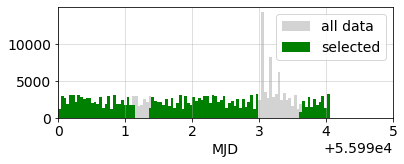

In [26]:
display_markdown("""### Test GTI
Extract photon data for a week containing two solar flares, check that 
they get excluded.
""")
interval = (55990, 55995)
dv = DataView(interval, gti=GTI.from_FITS('nosolarflares.gti'))
print(dv)
wk =dv.photon_week(dv[0])
t = wk['time']
dv_nocut = DataView(interval)
wk_nocut = dv_nocut.photon_week(dv_nocut[0])
bins = np.linspace(t[0],t[-1], 100)
fig, ax = plt.subplots(figsize=(6,2))
ax.hist(wk_nocut['time'], bins=bins, color='lightgrey',label='all data');
ax.hist(t,bins=bins, color='green', label='selected');
ax.set(xlabel='MJD', xlim=interval)
ax.legend();

---

In [27]:
display_markdown("""## PixelView
Manage the data as a FITS file accepted by pointlike

This class uses a DataView, or a FITS file to load a set of pixels with counts
for a time interval.

The FITS format has two HDUs with columns as shown.

__BANDS__ 
* NSIDE (J) -- power of 2 up to 4096
* E_MIN (D), E_MAX (D) 
* EVENT_TYPE (J) -- 0 or 1 for Front, Back

__SKYMAP__
* PIX (I) -- pixel index (RING) ordering now, but can be specified in header.
* CHANNEL (I) -- band index
* VALUE (J) -- number of events

Currently the wtlike photons are all stored with nside 1024, while the pointlike files 
go up to 4096, simply because that it the largest for 32 bits.


""")

Obsolete: use "show"


## PixelView
Manage the data as a FITS file accepted by pointlike

This class uses a DataView, or a FITS file to load a set of pixels with counts
for a time interval.

The FITS format has two HDUs with columns as shown.

__BANDS__ 
* NSIDE (J) -- power of 2 up to 4096
* E_MIN (D), E_MAX (D) 
* EVENT_TYPE (J) -- 0 or 1 for Front, Back

__SKYMAP__
* PIX (I) -- pixel index (RING) ordering now, but can be specified in header.
* CHANNEL (I) -- band index
* VALUE (J) -- number of events

Currently the wtlike photons are all stored with nside 1024, while the pointlike files 
go up to 4096, simply because that it the largest for 32 bits.

In [28]:
#| export

def project_to_map(pixel_dict, nside, to_nside=None, nest=True):
    """ Return a HEALPix map, of the data for a band, perhaps projected

    - pixel_dict -- dict-like of pixel numbers, counts
    - nside  -- for pixels
    - to_nside [None] -- for projected map: if None, set to pixel nside
            Error if greater than data's
    - nest [False] -- if data is RING, must convert back and forth for conversion

    """
    import warnings
    cpix   = pixel_dict
    bnside = nside
    if to_nside is None:
        to_nside = bnside
    else:
        assert to_nside <= bnside, f'Expect projected nside {to_nside} to be <= pixel nside, {bnside}'
    factor = int((bnside//to_nside)**2)

    amap  = np.zeros(12*to_nside**2,int)
    idx = np.array(list(pixel_dict.keys()))
    if not nest:
        # all hit pixel to NEST for projectio
        idx = healpy.ring2nest(nside, idx)
    if factor>1: idx //= factor
    cnt = pixel_dict.values()
    for pix, n in zip(idx, cnt): 
        amap[pix] += n
    if not nest:
        # back to RING, just reorder map
        amap = healpy.reorder(amap, n2r=True)
    return amap

class PixelView:
    
    """ Define a pixel-based database, associating a total count with
    a set of pixels for each band. 
    That, is make a view that is integrated over time.

    """
    
    def __init__(self, dataview, ):
        """Initialize from a DataView object
        

        """
        from collections import Counter

        # From pointlike, except this ends at nside 1024. Determine the
        # number of bits to shift each data pixel
        self.nsides = 2**np.array(
            [ [6, 6, 7, 8, 9,10]+[10]*10,
              [6, 7, 8, 9,10,10]+[10]*10 ]).T.flatten()
        
        to_shift = 2*np.log2(1024//self.nsides).astype(int)
        
        self.interval=dataview.time_range
        self.ebins = dataview.config.energy_edges

        # initialize empty Counters 
        self.pixels = dict( (band, Counter()) for band in range(32))

        # loop over the selected weeks
        for week in dataview:
            photons= pd.DataFrame(dataview.photon_week(week))
            for band, g in photons.groupby('band'):
                if band>31: break # ignore >1 TeV for now
                shift = to_shift[band]
                self.pixels[band].update( Counter(np.right_shift(g.nest_index,shift)) )
        
    def __repl__(self):
        return f'PixelView interval {self.interval}'
    
    def plot_pixel_counts(self, ax=None, **kwargs):
        """
        """
        npix, ncnt = np.array([ (len(v),sum(v.values())) for v in self.pixels.values()]).T
        fig,ax = plt.subplots(figsize=(5,4)) if ax is None else (ax.figure, ax)
        ax.semilogy(npix,'+', label=f'{sum(npix)/1e6:.1f}M pixels');
        ax.plot(ncnt, 'x', label=f'{sum(ncnt)/1e6:.1f}M counts');
        kw = dict(xlabel='band index')
        kw.update(kwargs)
        ax.set(**kw)
        ax.grid(alpha=0.5);ax.legend();
        
#     def get_map(self, band, nside=None):
#         """ Return a HEALPix map, of the data for a band, perhaps projected

#         - band -- the band index
#         - nside [None] -- for projected map: if None, set to data's nside
#                 Error if greater than data's

#         """
#         return project_to_map(self
# #         import warnings
# #         cpix   = self.pixels[band]
# #         bnside = self.nsides[band]
# #         if nside is None:
# #             nside = bnside
# #         else:
# #             assert nside <= bnside, f'Expect projected nside {nside} to be <= band nside, {bnside}'
# #         factor = int((bnside//nside)**2)

# #         amap  = np.zeros(12*nside**2,int)
# #         with warnings.catch_warnings(record=True) as w:
# #             warnings.simplefilter("always")
# #             for pix, n in cpix.items(): 
# #                 amap[pix//factor] += n
# #         return amap

    def mollview(self,  band, nside=None, **kwargs):
        """
        Generate a healpy.mollview image of a band's data
        """
        amap = project_to_map(self.pixels[band], self.nsides[band], to_nside=nside)
                              
        kw = dict( unit='log10(counts)',  title=f'Band {band}')
        kw.update(kwargs)   
        logmap = np.log10(amap, where=amap>0)
        healpy.mollview(logmap, nest=True, **kw) 
        
    def to_fits(self, outfile='test.fits', nest=False, overwrite=True):
        """
        - nest [False] -- set to True to generate NEST ordering, otherwise RING
        """
        
        # BANDS HDU
        energy_index = np.arange(32)//2
        event_type = np.bitwise_and(np.arange(32),1)
        elow, ehigh = self.ebins[:-1], self.ebins[1:]
        e_min = np.array([elow[i] for i in energy_index])
        e_max = np.array([ehigh[i] for i in energy_index])

        band_cols = [
            fits.Column(name='NSIDE', format='J', array=self.nsides),
            fits.Column(name='E_MIN', format='D', array=e_min*1e+3, unit='keV'),
            fits.Column(name='E_MAX', format='D', array=e_max*1e+3, unit='keV'),
            fits.Column(name='EVENT_TYPE', format='J', array=event_type),
        ]
        bands_hdu=fits.BinTableHDU.from_columns(band_cols, name='BANDS')
        
        # SKYMAP HDU
        pix = [];  cnt = [];  chn = []
        for i, v in self.pixels.items():
            bpix = v.keys()
            if not nest:
                bpix = list(healpy.nest2ring(self.nsides[i], list(bpix) ))
            n = len(v)
            chn += [i]*n
            pix += bpix
            cnt += v.values()  

        skymap_cols = [
            fits.Column(name='PIX', format='J',    array=pix),
            fits.Column(name='CHANNEL', format='I',array=chn),
            fits.Column(name='VALUE', format='J',  array=cnt),
        ]
        skymap_hdu=fits.BinTableHDU.from_columns(skymap_cols, name='SKYMAP')
        skymap_hdu.header.update(
            PIXTYPE='HEALPIX',
            INDXSCHM='SPARSE',
            ORDERING='NEST' if nest else 'RING',
            COORDSYS='GAL',
            BANDSHDU='BANDS',
            AXCOLS='E_MIN,E_MAX',
                    )
        # no GTI
        hdus = [fits.PrimaryHDU(),  skymap_hdu, bands_hdu]    #, self.ft1_hdus['GTI']]
        if outfile is not None:
            fits.HDUList(hdus).writeto(outfile, overwrite=overwrite)
    #------------------- need to be integrated --------------------
    @classmethod
    def read_fits(cls, file):
        with fits.open(file) as hdus:
            bands = hdus['BANDS'].data
            skymap = hdus['SKYMAP'].data
            nest = hdus['SKYMAP'].header['ORDERING']=='NEST'

        ic = np.append(np.searchsorted(skymap.CHANNEL, np.arange(32)), int(1e8))
        pixels={}
        chan, pix, cnts = skymap.CHANNEL, skymap.PIX, skymap.VALUE
        for band  in range(32):
            inchan = chan==band
            pixels[band] = dict( (p,c) for (p,c) in zip(pix[inchan],cnts[inchan]) )
        return bands, pixels, nest

    @classmethod
    def project_map(cls, pixel_dict, nside, to_nside=None, nest=False):
        """ Return a HEALPix map, of the data for a band, perhaps projected

        - pixel_dict -- dict-like of pixel numbers, counts
        - nside  -- for pixels
        - to_nside [None] -- for projected map: if None, set to pixel nside
                Error if greater than data's
        - nest [False] -- if data is RING, must convert back and forth for conversion

        """
        import warnings
        cpix   = pixel_dict
        bnside = nside
        if to_nside is None:
            to_nside = bnside
        else:
            assert to_nside <= bnside, f'Expect projected nside {to_nside} to be <= pixel nside, {bnside}'
        factor = int((bnside//to_nside)**2)

        amap  = np.zeros(12*to_nside**2,int)
        idx = np.array(list(pixel_dict.keys()))
        if not nest:
            # all hit pixel to NEST for projectio
            idx = healpy.ring2nest(nside, idx)
        if factor>1: idx //= factor
        cnt = pixel_dict.values()
        for pix, n in zip(idx, cnt): 
            amap[pix] += n
        if not nest:
            # back to RING, just reorder map
            amap = healpy.reorder(amap, n2r=True)
        return amap

In [29]:
show_doc(PixelView, title_level=3)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/data_man.py#L811){target="_blank" style="float:right; font-size:smaller"}

### PixelView

>      PixelView (dataview)

Define a pixel-based database, associating a total count with
a set of pixels for each band. 
That, is make a view that is integrated over time.

Obsolete: use "show"


### Test with subset
Start with: DataView((54683, 55048)), 53 weekly files)

elapsed time: 8.9s (0.1 min)


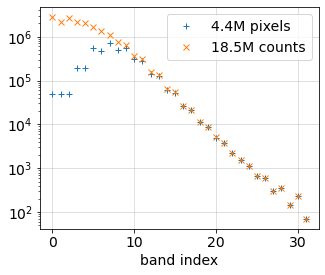

In [30]:
#| include: false
dv = DataView((0,365))
display_markdown(f"""### Test with subset
Start with: {dv}
""")
with Timer() as t:
    pm = PixelView(dv)
    print(t)
pm.plot_pixel_counts()

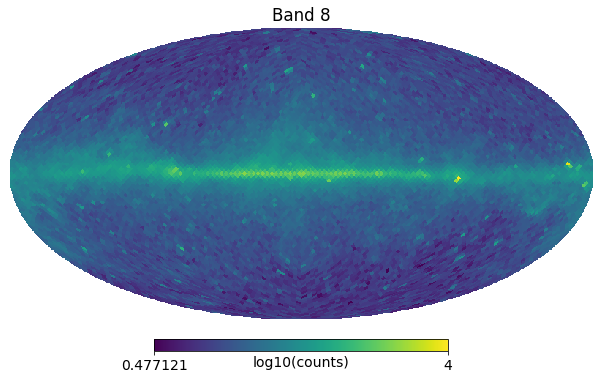

In [31]:
pm.mollview(8, 32, max=4)
#pm.mollview(6); # second time works--mystery TODO

In [32]:
#| include: false

display_markdown(f"""### Write FITS files with RING and NEST ordering
Then read back and display.
                 """)
for nest in (True, False):
    file = f'/tmp/pixeltest_nest_{nest}.fits'  
    pm.to_fits(file, nest=nest)

Obsolete: use "show"


### Write FITS files with RING and NEST ordering
Then read back and display.
                 

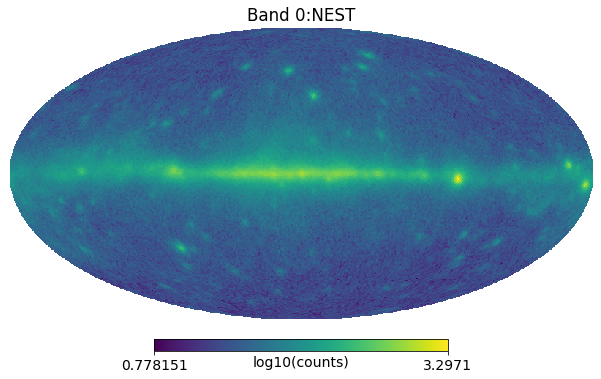

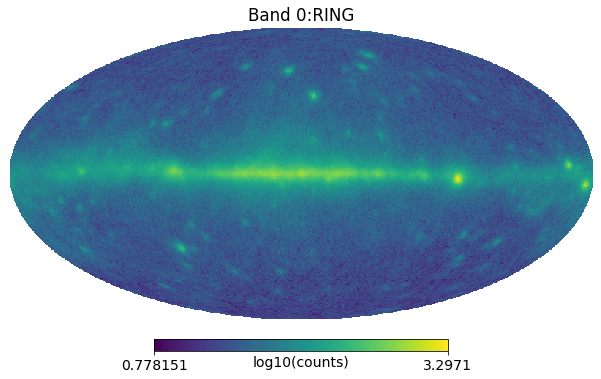

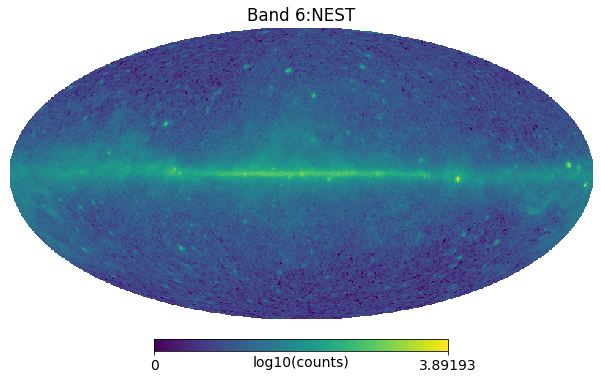

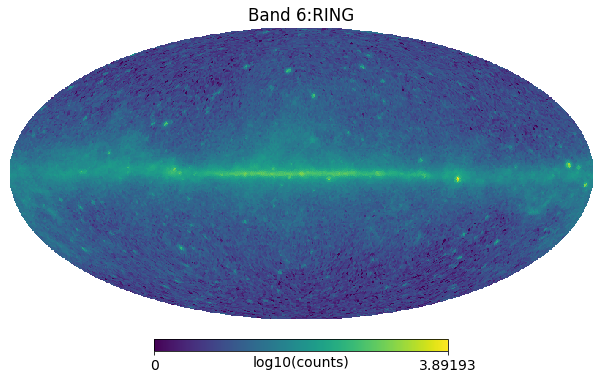

In [33]:
fignum=1
for band in (0,6):
    for nest in (True, False):
        file = f'/tmp/pixeltest_nest_{nest}.fits'
        bands, pixels, nest = PixelView.read_fits(file)
        pmap = PixelView.project_map(pixels[band], bands.NSIDE[band], 64, nest=nest)

        logmap = np.log10(pmap,where=pmap>0)
        healpy.mollview(logmap, fig=fignum ,
                        nest=nest, title=f'Band {band}:{"NEST" if nest else "RING"}', 
                        unit='log10(counts)')
        fignum+=1

In [34]:
# file = f'/tmp/pixeltest_nest_True.fits'
# bands, pixels, nest = read_fits(file)
# pmap = project_map(pixels[8], nside[8], 64, nest=nest)
# logmap = np.log10(pmap,where=pmap>0)

# healpy.mollview(logmap, nest=nest, title='', unit='log10(counts)')

# file = f'/tmp/pixeltest_nest_True.fits'
# bands, pixels, nest = read_fits(file)
# pmap = project_map(pixels[8], nside[8], 64, nest=nest)
# logmap = np.log10(pmap,where=pmap>0)

# healpy.mollview(logmap, nest=nest, title=file, unit='log10(counts)')

# file = f'/tmp/pixeltest_nest_False.fits'
# bands, pixels, nest = read_fits(file)
# pmap = project_map(pixels[8], nside[8], 64, nest=nest)
# logmap = np.log10(pmap,where=pmap>0)

# healpy.mollview(logmap, nest=nest, title=file, unit='log10(counts)')

In [38]:
#| include: false
import datetime
show(f'## Finish build: {str(datetime.datetime.now())[:16]}')
from nbdev import nbdev_export
nbdev_export()


## Finish build: 2023-06-19 11:00

In [36]:

#| include: false
# def read_fits(file):
#     with fits.open(file) as hdus:
#         bands = hdus['BANDS'].data
#         skymap = hdus['SKYMAP'].data
#         nest = hdus['SKYMAP'].header['ORDERING']=='NEST'

#     ic = np.append(np.searchsorted(skymap.CHANNEL, np.arange(32)), int(1e8))
#     pixels={}
#     chan, pix, cnts = skymap.CHANNEL, skymap.PIX, skymap.VALUE
#     for band  in range(32):
#         inchan = chan==band
#         pixels[band] = dict( (p,c) for (p,c) in zip(pix[inchan],cnts[inchan]) )
#     return bands, pixels, nest

# def project_map(pixel_dict, nside, to_nside=None, nest=False):
#     """ Return a HEALPix map, of the data for a band, perhaps projected

#     - pixel_dict -- dict-like of pixel numbers, counts
#     - nside  -- for pixels
#     - to_nside [None] -- for projected map: if None, set to pixel nside
#             Error if greater than data's
#     - nest [False] -- if data is RING, must convert back and forth for conversion

#     """
#     import warnings
#     cpix   = pixel_dict
#     bnside = nside
#     if to_nside is None:
#         to_nside = bnside
#     else:
#         assert to_nside <= bnside, f'Expect projected nside {to_nside} to be <= pixel nside, {bnside}'
#     factor = int((bnside//to_nside)**2)

#     amap  = np.zeros(12*to_nside**2,int)
#     idx = np.array(list(pixel_dict.keys()))
#     if not nest:
#         # all hit pixel to NEST for projectio
#         idx = healpy.ring2nest(nside, idx)
#     if factor>1: idx //= factor
#     cnt = pixel_dict.values()
#     for pix, n in zip(idx, cnt): 
#         amap[pix] += n
#     if not nest:
#         # back to RING, just reorder map
#         amap = healpy.reorder(amap, n2r=True)
#     return amap